In [1]:
cd data/

c:\Users\Andrew\Documents\Udacity\Intro_Data_Science\introDSRepo\data


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Udacity Introduction to Data Science Final Project#

**Author: Andrew Bauman**

This is the final project for Udacity's Introduction to Data Science the first course in the Data Analyst Nanodegree program.  During this course we analyzed NYC subway data from May 2011.  We wrangled and interrogated the data and recieved an introduction to I/O methods. 

**Methods and tools of interrogation included:**

- SQL Queries
- Linear Regression/Gradient Descent
- Map Reduce
- PANDASfu, not to be confused with Kung Fu Panda


**The following narrative is my selected work from the course.  We will cover:**

- Data Wrangling
- Data Survey/Exploration
- Selected Data Analysis and Visualization

The most important part of science, including Data Science is asking the right question.  The question asked guides the analyst through constraint and scope.  This maximizes the potential for success while minimizing the chances of wasting resources (time, computational power) etc.  Formation of a sound hypothesis and testing that hypothesis is fundamental to any scientific pursuit.  

**Basic Question:** Does weather (i.e. precipitation, temperature, ...) impact subway use?

The data set we are using in this class (May 2011) is fairly limited in terms of ranges of values for factors such as temperature and pressure.  This limits our pool of meaningful analyses.  However, a single month is a great bite sized chunk for an introduction to Data Science skills, and to test methods and tools.  Success with this small data set can be modified and scaled to additional months and years of data.

**So what do we need to do to answer this basic question and related questions?**
Prior to exploring the data it is difficult to say exactly what approach we will take.  However, we do know that we will need to join subway and weather data.  Prior to doing this it is likely that we will need to clean, reshape, and harmonize either or both data sets

##Data Wrangling (Yeeeee Hawww!)##

This is often a very time intensive portion of data analysis, and can often be an iterative process.

###Fixing Turnstile Data:###  
We begin with text files.  Exploring the text file structure, we see there is some cleaning to be accomplished.

In [3]:
import csv

def fix_turnstile_data(filenames): #accepts a list ['filname1','filename2'......], breaks each row of each file into individual records and returns a clean file
    '''
    Filenames is a list of MTA Subway turnstile text files. A link to an example
    MTA Subway turnstile text file can be seen at the URL below:
    http://web.mta.info/developers/data/nyct/turnstile/turnstile_110507.txt
    
    As you can see, there are numerous data points included in each row of the
    a MTA Subway turnstile text file. 

    You want to write a function that will update each row in the text
    file so there is only one entry per row. A few examples below:
    A002,R051,02-00-00,05-28-11,00:00:00,REGULAR,003178521,001100739
    A002,R051,02-00-00,05-28-11,04:00:00,REGULAR,003178541,001100746
    A002,R051,02-00-00,05-28-11,08:00:00,REGULAR,003178559,001100775
    
    Write the updates to a different text file in the format of "updated_" + filename.
    For example:
        1) if you read in a text file called "turnstile_110521.txt"
        2) you should write the updated data to "updated_turnstile_110521.txt"

    The order of the fields should be preserved. 
    
    You can see a sample of the turnstile text file that's passed into this function
    and the the corresponding updated file in the links below:
    
    Sample input file:
    https://www.dropbox.com/s/mpin5zv4hgrx244/turnstile_110528.txt
    Sample updated file:
    https://www.dropbox.com/s/074xbgio4c39b7h/solution_turnstile_110528.txt
    '''


    for name in filenames:
        #open reader read file, write file, reader, and writer
        with open(name, "rb") as f, open("updated_" + name, "wb") as fw: # open reader and writer and establish name of write file
             reader = csv.reader(f)
             writer = csv.writer(fw)
                #start parsing read file by row
             for row in reader:
                  header = row[:3] #columns 1-3 , the remaining entries in each row apply to this header data
                  #list comprehension, fields repeat every 5 columns, slice out every 5 until the end of the row and put them in the list lines
                  lines = [row[x:x+5] for x in range(3, len(row), 5)] 
                  # iterate over lines, combine each element of lines with the header and write it to a file as named above
                  for item in lines:
                      writer.writerow(header + item)

In [4]:
fix_turnstile_data(['turnstile_110507.txt'])

###Consolidate Fixed Files and Combine them into a Master File###

For the fix_turnstile_data() function, we produce an updated file for each file in the list.  These need to be merged into a single, master file.

In [5]:
def create_master_turnstile_file(filenames, output_file): #accepts filename list and combines contents into a single master file 
    #names as the output_file argument
    '''
    Write a function that takes the files in the list filenames, which all have the 
    columns 'C/A, UNIT, SCP, DATEn, TIMEn, DESCn, ENTRIESn, EXITSn', and consolidates
    them into one file located at output_file.  There should be ONE row with the column
    headers, located at the top of the file.
    
    For example, if file_1 has:
    'C/A, UNIT, SCP, DATEn, TIMEn, DESCn, ENTRIESn, EXITSn'
    line 1 ...
    line 2 ...
    
    and another file, file_2 has:
    'C/A, UNIT, SCP, DATEn, TIMEn, DESCn, ENTRIESn, EXITSn'
    line 3 ...
    line 4 ...
    line 5 ...
    
    We need to combine file_1 and file_2 into a master_file like below:
     'C/A, UNIT, SCP, DATEn, TIMEn, DESCn, ENTRIESn, EXITSn'
    line 1 ...
    line 2 ...
    line 3 ...
    line 4 ...
    line 5 ...
    '''
    with open(output_file, 'w') as master_file: # open a file object
       master_file.write('C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn\n') #write into the file object using a header argument
       for filename in filenames: #iterate over the filename list
            with open(filename, 'rb') as f: #open each file name as an object, read each line, write each line to the masterfile
                f.readline()
                master_file.writelines(f)
                


In [6]:
create_master_turnstile_file(['updated_turnstile_110507.txt'],'joeyjoejoe.txt')

###Filter the Data:###
For purpsoses of our analysis we only want REGULAR data, typically associated with active lifestyles and high fiber diets.

In [7]:
import pandas as pd


def filter_by_regular(filename): #accepts a masterfile, reads file and drops it into a PANDAS DataFrame, filters, returns the filtered DataFrame
  
    '''
    This function should read the csv file located at filename into a pandas dataframe,
    and filter the dataframe to only rows where the 'DESCn' column has the value 'REGULAR'.
    
    For example, if the pandas dataframe is as follows:
    ,C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn
    0,A002,R051,02-00-00,05-01-11,00:00:00,REGULAR,3144312,1088151
    1,A002,R051,02-00-00,05-01-11,04:00:00,DOOR,3144335,1088159
    2,A002,R051,02-00-00,05-01-11,08:00:00,REGULAR,3144353,1088177
    3,A002,R051,02-00-00,05-01-11,12:00:00,DOOR,3144424,1088231
    
    The dataframe will look like below after filtering to only rows where DESCn column
    has the value 'REGULAR':
    0,A002,R051,02-00-00,05-01-11,00:00:00,REGULAR,3144312,1088151
    2,A002,R051,02-00-00,05-01-11,08:00:00,REGULAR,3144353,1088177
    '''
    
    turnstile_data = pd.read_csv(filename)#read in the csv, doing this first avoids problems with creating the DataFrame
    turnstile_data = pd.DataFrame(turnstile_data) #create the DataFrame
    turnstile_data = turnstile_data[turnstile_data.DESCn == 'REGULAR']#Filter the DataFrame, [whatever is here acts like a WHERE statement ins SQL]
    
    
    return turnstile_data

In [8]:
frame = filter_by_regular('joeyjoejoe.txt')
frame.head()

,C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn
0,A002,R051,02-00-00,04-30-11,04:00:00,REGULAR,3143547,1087915
2,A002,R051,02-00-00,04-30-11,08:00:00,REGULAR,3143563,1087935
4,A002,R051,02-00-00,04-30-11,12:00:00,REGULAR,3143646,1088024
6,A002,R051,02-00-00,04-30-11,16:00:00,REGULAR,3143865,1088083
8,A002,R051,02-00-00,04-30-11,20:00:00,REGULAR,3144181,1088132


In [9]:
import pandas as pd
'''accepts a PANDAS DataFrame, creates a new column ENTRIESn_hourly assinging a value of 
    the difference between the current and previous row,  #or 1 for any value = NaN, then returns a DataFrame'''
def get_hourly_entries(df): 
    '''
    The data in the MTA Subway Turnstile data reports on the cumulative
    number of entries and exits per row.  Assume that you have a dataframe
    called df that contains only the rows for a particular turnstile machine
    (i.e., unique SCP, C/A, and UNIT).  This function should change
    these cumulative entry numbers to a count of entries since the last reading
    (i.e., entries since the last row in the dataframe).
    
    More specifically, you want to do two things:
       1) Create a new column called ENTRIESn_hourly
       2) Assign to the column the difference between ENTRIESn of the current row 
          and the previous row. If there is any NaN, fill/replace it with 1.
    
    You may find the pandas functions shift() and fillna() to be helpful in this exercise.
    
    Examples of what your dataframe should look like at the end of this exercise:
    
           C/A  UNIT       SCP     DATEn     TIMEn    DESCn  ENTRIESn    EXITSn  ENTRIESn_hourly
    0     A002  R051  02-00-00  05-01-11  00:00:00  REGULAR   3144312   1088151                1
    1     A002  R051  02-00-00  05-01-11  04:00:00  REGULAR   3144335   1088159               23
    2     A002  R051  02-00-00  05-01-11  08:00:00  REGULAR   3144353   1088177               18
    3     A002  R051  02-00-00  05-01-11  12:00:00  REGULAR   3144424   1088231               71
    4     A002  R051  02-00-00  05-01-11  16:00:00  REGULAR   3144594   1088275              170
    5     A002  R051  02-00-00  05-01-11  20:00:00  REGULAR   3144808   1088317              214
    6     A002  R051  02-00-00  05-02-11  00:00:00  REGULAR   3144895   1088328               87
    7     A002  R051  02-00-00  05-02-11  04:00:00  REGULAR   3144905   1088331               10
    8     A002  R051  02-00-00  05-02-11  08:00:00  REGULAR   3144941   1088420               36
    9     A002  R051  02-00-00  05-02-11  12:00:00  REGULAR   3145094   1088753              153
    10    A002  R051  02-00-00  05-02-11  16:00:00  REGULAR   3145337   1088823              243
    ...
    ...

    '''

    df['ENTRIESn_hourly'] = df.ENTRIESn.diff(1) #create the column and assign value
    df.ENTRIESn_hourly.fillna(1, inplace = True) #fill NaN with 1
    
    return df

In [10]:
frame2= get_hourly_entries(frame)
frame.head()

,C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn,ENTRIESn_hourly
0,A002,R051,02-00-00,04-30-11,04:00:00,REGULAR,3143547,1087915,1
2,A002,R051,02-00-00,04-30-11,08:00:00,REGULAR,3143563,1087935,16
4,A002,R051,02-00-00,04-30-11,12:00:00,REGULAR,3143646,1088024,83
6,A002,R051,02-00-00,04-30-11,16:00:00,REGULAR,3143865,1088083,219
8,A002,R051,02-00-00,04-30-11,20:00:00,REGULAR,3144181,1088132,316


In [11]:
import pandas
'''accepts a PANDAS DataFrame, creates a new column EXITSn_hourly assinging a value of 
the difference between the current and previous row,  #or 1 for any value = NaN, then returns a DataFrame'''

def get_hourly_exits(df): 
    '''
    The data in the MTA Subway Turnstile data reports on the cumulative
    number of entries and exits per row.  Assume that you have a dataframe
    called df that contains only the rows for a particular turnstile machine
    (i.e., unique SCP, C/A, and UNIT).  This function should change
    these cumulative exit numbers to a count of exits since the last reading
    (i.e., exits since the last row in the dataframe).
    
    More specifically, you want to do two things:
       1) Create a new column called EXITSn_hourly
       2) Assign to the column the difference between EXITSn of the current row 
          and the previous row. If there is any NaN, fill/replace it with 0.
    
    You may find the pandas functions shift() and fillna() to be helpful in this exercise.
    
    Example dataframe below:

          Unnamed: 0   C/A  UNIT       SCP     DATEn     TIMEn    DESCn  ENTRIESn    EXITSn  ENTRIESn_hourly  EXITSn_hourly
    0              0  A002  R051  02-00-00  05-01-11  00:00:00  REGULAR   3144312   1088151                0              0
    1              1  A002  R051  02-00-00  05-01-11  04:00:00  REGULAR   3144335   1088159               23              8
    2              2  A002  R051  02-00-00  05-01-11  08:00:00  REGULAR   3144353   1088177               18             18
    3              3  A002  R051  02-00-00  05-01-11  12:00:00  REGULAR   3144424   1088231               71             54
    4              4  A002  R051  02-00-00  05-01-11  16:00:00  REGULAR   3144594   1088275              170             44
    5              5  A002  R051  02-00-00  05-01-11  20:00:00  REGULAR   3144808   1088317              214             42
    6              6  A002  R051  02-00-00  05-02-11  00:00:00  REGULAR   3144895   1088328               87             11
    7              7  A002  R051  02-00-00  05-02-11  04:00:00  REGULAR   3144905   1088331               10              3
    8              8  A002  R051  02-00-00  05-02-11  08:00:00  REGULAR   3144941   1088420               36             89
    9              9  A002  R051  02-00-00  05-02-11  12:00:00  REGULAR   3145094   1088753              153            333
    '''
    
    df['EXITSn_hourly'] = df.EXITSn.diff(1)
    df.EXITSn_hourly.fillna(0,inplace = True)
    return df


In [12]:
frame3 = get_hourly_exits(frame2)
frame3.head()

,C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly
0,A002,R051,02-00-00,04-30-11,04:00:00,REGULAR,3143547,1087915,1,0
2,A002,R051,02-00-00,04-30-11,08:00:00,REGULAR,3143563,1087935,16,20
4,A002,R051,02-00-00,04-30-11,12:00:00,REGULAR,3143646,1088024,83,89
6,A002,R051,02-00-00,04-30-11,16:00:00,REGULAR,3143865,1088083,219,59
8,A002,R051,02-00-00,04-30-11,20:00:00,REGULAR,3144181,1088132,316,49


In [13]:
import datetime

def reformat_subway_dates(date): #a function to reformat dates, a tool to enable joining the subway and weather data
    '''
    The dates in our subway data are formatted in the format month-day-year.
    The dates in our weather underground data are formatted year-month-day.
    
    In order to join these two data sets together, we'll want the dates formatted
    the same way.  Write a function that takes as its input a date in the MTA Subway
    data format, and returns a date in the weather underground format.
    
    Hint: 
    There is a useful function in the datetime library called strptime. 
    More info can be seen here:
    http://docs.python.org/2/library/datetime.html#datetime.datetime.strptime
    '''

    date_formatted = datetime.datetime.strptime(date, '%m-%d-%y').strftime('%Y-%m-%d') #note that %Y returns four digit year %y returns 2 digit year
    return date_formatted



###Joining the Weather and Turnstile Data###
We didn't actually do this as part of the class.  My approach would have been to do any cleaning and reshaping required of the weather data, fix the datetime inconsistency, drop the weather data into a PANDAS DataFrame, then merge withe the turnstile DataFrame.

##Exploratory Data Analyis##
Before going any further it would be useful to explore the data and understand how it is distributed.

In [14]:
df_turnstile_weather = pd.DataFrame(pd.read_csv('turnstile_data_master_with_weather.csv'))

In [15]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

def entries_histogram(turnstile_weather):
    '''
    Before we perform any analysis, it might be useful to take a
    look at the data we're hoping to analyze. More specifically, let's 
    examine the hourly entries in our NYC subway data and determine what
    distribution the data follows. This data is stored in a dataframe
    called turnstile_weather under the ['ENTRIESn_hourly'] column.
    
    Let's plot two histograms on the same axes to show hourly
    entries when raining vs. when not raining. Here's an example on how
    to plot histograms with pandas and matplotlib:
    turnstile_weather['column_to_graph'].hist()
    
    Your histograph may look similar to bar graph in the instructor notes below.
    
    You can read a bit about using matplotlib and pandas to plot histograms here:
    http://pandas.pydata.org/pandas-docs/stable/visualization.html#histograms
    
    You can see the information contained within the turnstile weather data here:
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
    '''
    
    plt.figure() #create a plot object which we will popluate with histograms
    
    turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 1].hist(bins = 25, range=(0,6000)) # raining, includes bins and range args
    turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain == 0].hist(bins = 25,alpha = .4,range = (0,6000)) # not raining includes bins, range, and alpha transparency args
    plt.xlabel("ENTRIESn_hourly")
    plt.ylabel('Frequency')
    plt.legend(('Rain','No Rain'))
    plt.title('Ridership Distribution for Rain and No Rain Conditions')
    return plt


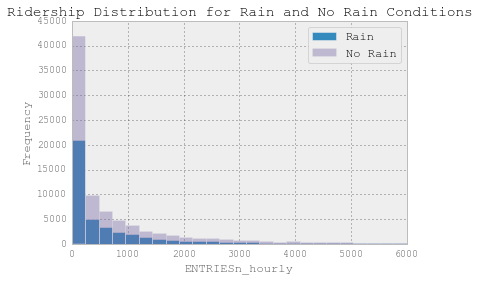

In [16]:
entries_histogram(df_turnstile_weather);

Is this a normal distribution?  Not even close.  Can we use Welch's t test to determine if the there is a significant difference in the distribution of these two populations?  No, Welch's t test assumes a normal distribution and therefore is not applicable in this case.

So how are we going to test our null hypothesis (that there is no difference in ridership between rainy and non-rainy days)?  We will need a test that can accomadate a non-normal distribution.  The Mann-Whitney U Test is one such test.

###Is the Mann-Whitney U Test Appropriate?###
According to my reading (https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php) 3 assumptions must be met to apply the Mann-Whitney U test.

###Design###
 - You have one dependent variable that is measured at the continuous or ordinal level.
 - You have one independent variable that consists of two categorical, independent groups.
 - You should have independence of observations.
 
###Interpretation###
 
The nature of your data will affect how you interpret the test. You should determine whether the distribution of scores for both groups of your independent variable have the same shape or a different shape.  If the data have the same shape then you may use the test to determine whether there are differences in the distributions.  If the data have a different shape, you may use the test to determine if there is a difference in the median of the two groups.
 
 For our data the 3 design criteria are met.  Our histograms above demonstrate reasonable similiarity in shape that we can use the Mann-Whitney U test to determine if there are differences in distributions of the two groups (rain, no rain).

###Applying the Mann-Whitney U Test (Can We Blame it On the Rain?)###

In [17]:
import numpy as np
import scipy
import scipy.stats
import pandas

def mann_whitney_plus_means(turnstile_weather): 
    '''This function accepts a PANDAS DataFrame and respective to ENTRIESn_houly, returns the mean of the raining and not raining conditons
    test statistic, and p value.'''
    '''
    This function will consume the turnstile_weather dataframe containing
    our final turnstile weather data. 
    
    You will want to take the means and run the Mann Whitney U-test on the 
    ENTRIESn_hourly column in the turnstile_weather dataframe.
    
    This function should return:
        1) the mean of entries with rain
        2) the mean of entries without rain
        3) the Mann-Whitney U-statistic and p-value comparing the number of entries
           with rain and the number of entries without rain
    
    You should feel free to use scipy's Mann-Whitney implementation, and you 
    might also find it useful to use numpy's mean function.
    
    Here are the functions' documentation:
    http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
    
    You can look at the final turnstile weather data at the link below:
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
    '''
    

    with_rain_mean = np.mean(turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain ==1])
    without_rain_mean = np.mean(turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain ==0])
    U, p = scipy.stats.mannwhitneyu(turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain ==1],turnstile_weather['ENTRIESn_hourly'][turnstile_weather.rain ==0])
    if p <.05:
        result = 'Blame it on the Rain!'
    else:
        result = 'What you talkin' 'bout Willis!'
    
    print'Result: {0}\nMean(Rain): {1}\nMean(No Rain) {2}\nU: {3}\none-sided p: {4}\ntwo-sided p {5} '.format(result,with_rain_mean, without_rain_mean, U, p, p*2)


In [18]:
mann_whitney_plus_means(df_turnstile_weather)

Result: Blame it on the Rain!
Mean(Rain): 1105.44637675
Mean(No Rain) 1090.27878015
U: 1924409167.0
one-sided p: 0.0193096344138
two-sided p 0.0386192688276 


**According to the results of the Mann-Whitney U test our null hypothesis appears false, so yes, the rain did it.**

##Data Visualization and Exploration##
Prior to moving to computational methods such as regression analysis I want to get a better feel for the data through visualization.  I explored a variety of visualizations, some worked out and some didn't.  Selected visualizations follow.

*Note that when I originally performed these visualizations the legends were displaying.  Since then I have updated Anaconda python, since then I have not been able to get the legends to appear.

###Ridership by Hour###
*Placed in this order to give access to turnstile_dt object*

In [19]:
import pandas as pd
from ggplot import *

def plot_weather_data(turnstile_weather):
    '''
    You are passed in a dataframe called turnstile_weather. 
    Use turnstile_weather along with ggplot to make a data visualization
    focused on the MTA and weather data we used in assignment #3.  
    You should feel free to implement something that we discussed in class 
    (e.g., scatterplots, line plots, or histograms) or attempt to implement
    something more advanced if you'd like.  

    Here are some suggestions for things to investigate and illustrate:
     * Ridership by time of day or day of week
     * How ridership varies based on Subway station
     * Which stations have more exits or entries at different times of day

    If you'd like to learn more about ggplot and its capabilities, take
    a look at the documentation at:
    https://pypi.python.org/pypi/ggplot/
     
    You can check out:
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
     
    To see all the columns and data points included in the turnstile_weather 
    dataframe. 
     
    However, due to the limitation of our Amazon EC2 server, we are giving you about 1/3
    of the actual data in the turnstile_weather dataframe
    '''
    
# I am going to plot exits and entries by hour of day, then tie that to station (next exercise)
    data = turnstile_weather.copy()
    #Create datetime column
    data["datetime"] = pd.to_datetime(data.DATEn + " " + data.TIMEn, format="%Y-%m-%d %H:%M:%S")
    # Convert datetime column from str to a pandas datetime object
    data['datetime'] = pd.to_datetime(data.datetime, format='%Y-%m-%d %H:%M:%S')
    # Set datetime to index
    turnstile_dt = data[['datetime','ENTRIESn_hourly','EXITSn_hourly','UNIT']] \
               .set_index('datetime') \
               .sort_index()
    # Resample by hour and create hour field
    turnstile_hour = turnstile_dt.resample('H')
    turnstile_hour['Hour'] = turnstile_hour.index.hour
    turnstile_hour = turnstile_hour[['Hour', 'ENTRIESn_hourly', 'EXITSn_hourly']]
    
    # Stack using pd.melt() and plot
    plot = ggplot(pd.melt(turnstile_hour,id_vars=['Hour']), aes(x='Hour', y='value', color='variable')) +\
    geom_line() + ggtitle('Ridership by Hour of Day') + ylab('Entries/Exits')+theme_seaborn()
    
    
    return plot, turnstile_dt

In [20]:
ridership_hour_plot,turnstile_dt = plot_weather_data(df_turnstile_weather)

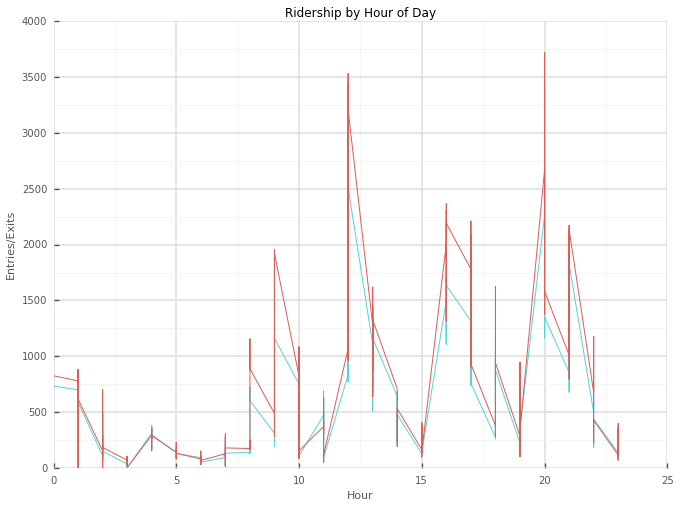

<ggplot: (29305025)>

In [21]:
ridership_hour_plot

The readability of the plot above has room for improvement.  A frequenc polygon may be appropriate, attempt to implement geom_freqpoly in python ggplot, failed.

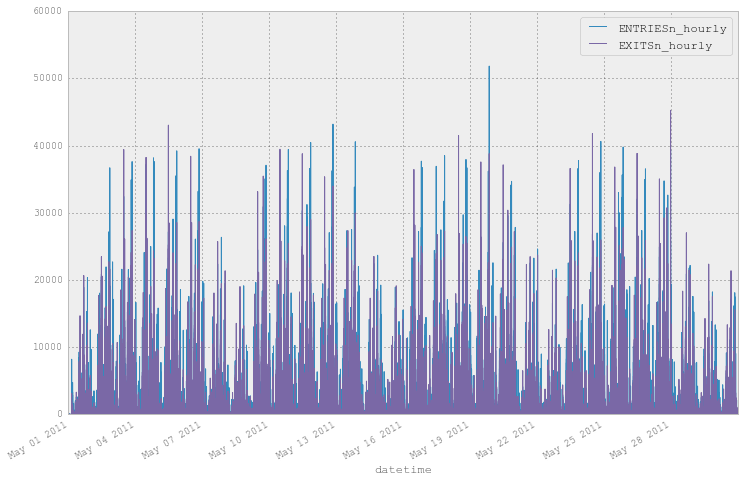

In [22]:
turnstile_dt.plot(figsize = (12,8));

It looks like ridership is cyclical.  Why the highs and lows?  Lets slice and dice this to see what we see

##Ridership by Day of Week##

**First the easy way**

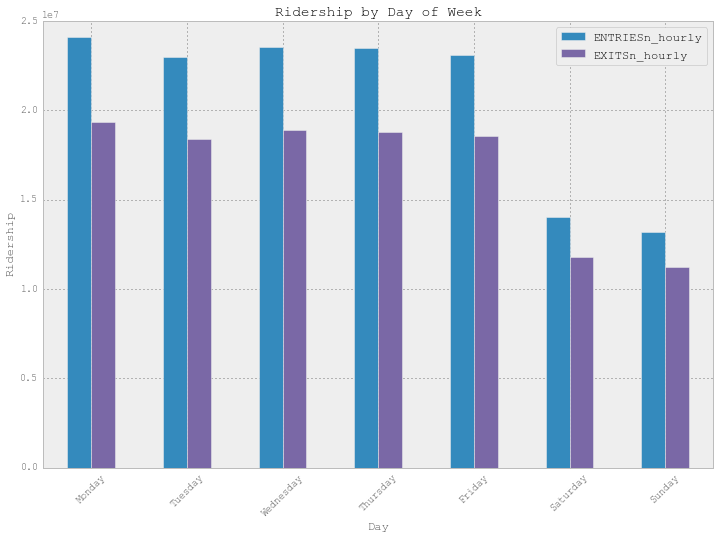

In [23]:
turnstile_day = turnstile_dt
turnstile_day["day"] = turnstile_day.index.weekday
turnstile_day = turnstile_day[["day", "ENTRIESn_hourly", "EXITSn_hourly"]] \
            .groupby("day").agg(sum)

turnstile_day.plot(kind = 'bar',figsize =(12,8))
pylab.xlabel('Day')
pylab.ylabel('Ridership')
pylab.title('Ridership by Day of Week')
pylab.xticks([0,1, 2, 3, 4, 5, 6], ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45);


**The GGPlot Way**

I grew weary of fighting the buggy python GGPlot for my initial visualizations so I abandoned it for now only returning to it to complete the problem sets.

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
A variable was mapped to y.
    stat_bin sets the y value to the count of cases in each group.
    The mapping to y was ignored.
    If you want y to represent values in the data, use stat="bar".
c:\Users\Andrew\Anaconda\lib\site-packages\pandas\util\decorators.py:53: FutureWarning: rows is deprecated, use index instead
  warnings.warn(msg, FutureWarning)


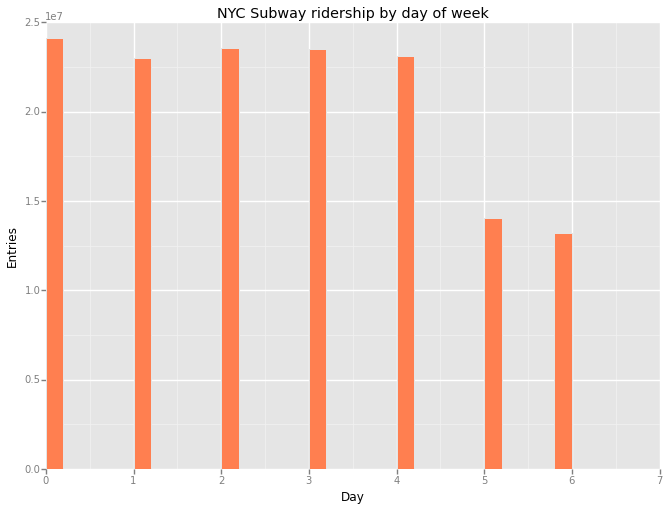

<ggplot: (14886891)>

In [24]:
plot = ggplot(turnstile_day, aes(x=turnstile_day.index, y='ENTRIESn_hourly')) \
           + geom_bar(aes(weight='ENTRIESn_hourly'), fill='coral') \
           + ggtitle('NYC Subway ridership by day of week') + xlab('Day') + ylab('Entries')
        
plot

More people ride the subway on weekdays than weekends, one would intuit that.  This explains the cyclical nature of the data.
Sometimes you can lose insight when summarizing data.  How does ridership vary by each day for each week of May? (ryhme intended, your move).

We know that Memorial Day is May 30th and I'm wondering if there are particularly slow or fast weekend days as well.  Let's see.

In [25]:
monday = turnstile_dt.ENTRIESn_hourly[turnstile_dt.day == 0].groupby(turnstile_dt[turnstile_dt.day == 0].index.date).agg(sum)
saturday = turnstile_dt.ENTRIESn_hourly[turnstile_dt.day == 5].groupby(turnstile_dt[turnstile_dt.day == 5].index.date).agg(sum)
sunday = turnstile_dt.ENTRIESn_hourly[turnstile_dt.day == 6].groupby(turnstile_dt[turnstile_dt.day == 6].index.date).agg(sum)

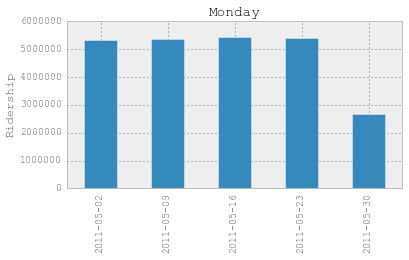

In [26]:
monday.plot(kind = 'bar',figsize =(6,3))
pylab.title('Monday')
pylab.ylabel('Ridership');

Yes, ridership is down on memorial day.

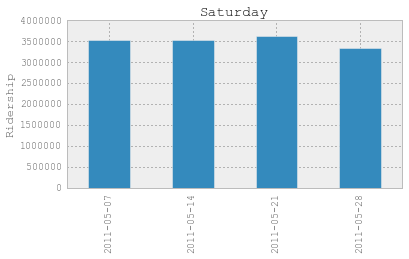

In [27]:
saturday.plot(kind = 'bar',figsize =(6,3))
pylab.title('Saturday')
pylab.ylabel('Ridership');

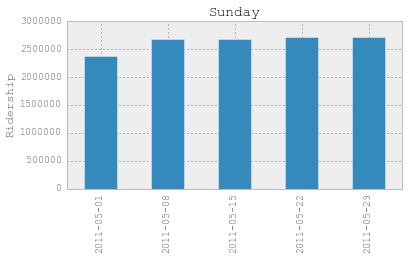

In [28]:
sunday.plot(kind = 'bar',figsize =(6,3))
pylab.title('Sunday')
pylab.ylabel('Ridership');

Conclusion = No Surprises

**What have we learned?**
- There may be differences in ridership as a function of hour
- There are differences in ridership on rainy vs. not rainy days
- There is more ridership on weekdays vs. weekends, except Memorial Day.


#Data Visualization#

##Top 10 and Bottom 10 Entries and Exits##

In [29]:
import pandas as pd
from ggplot import *

def plot_weather_data_topN(turnstile_weather):
    ''' 
    plot_weather_data is passed a dataframe called turnstile_weather. 
    Use turnstile_weather along with ggplot to make another data visualization
    focused on the MTA and weather data we used in Project 3.
    
    Make a type of visualization different than what you did in the previous exercise.
    Try to use the data in a different way (e.g., if you made a lineplot concerning 
    ridership and time of day in exercise #1, maybe look at weather and try to make a 
    histogram in this exercise). Or try to use multiple encodings in your graph if 
    you didn't in the previous exercise.
    
    You should feel free to implement something that we discussed in class 
    (e.g., scatterplots, line plots, or histograms) or attempt to implement
    something more advanced if you'd like.

    Here are some suggestions for things to investigate and illustrate:
     * Ridership by time-of-day or day-of-week
     * How ridership varies by subway station
     * Which stations have more exits or entries at different times of day

    If you'd like to learn more about ggplot and its capabilities, take
    a look at the documentation at:
    https://pypi.python.org/pypi/ggplot/
     
    You can check out the link 
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
    to see all the columns and data points included in the turnstile_weather 
    dataframe.
     
    However, due to the limitation of our Amazon EC2 server, we will give you only 
    about 1/3 of the actual data in the turnstile_weather dataframe.
    '''

    # I am going to plot entries and exits for the top and bottom 10 entry units
    data = turnstile_weather.copy()
    # Convert datetime column from str to a pandas datetime object
    data_units = data[['UNIT','ENTRIESn_hourly','EXITSn_hourly']]
    
    # Slice the top and bottom 10 units
    top10 = data_units.groupby('UNIT', as_index = False).sum().sort('ENTRIESn_hourly').tail(10)
    bot10 = data_units.groupby('UNIT', as_index = False).sum().sort('ENTRIESn_hourly').head(10) 
    
  
    
    # plot, note that dodge did not work for ggplot, also note that legend was displaying prior to anaconda upgrade
    plot_top = ggplot(pd.melt(top10,id_vars='UNIT'), aes(x='UNIT', y='value',color='variable', fill = 'variable')) +\
    geom_bar(stat = 'identity', position = 'fill') +\
    ggtitle('Top 10 Unit Hourly Entries and Exits') + ylab('Entries/Exits') + theme_seaborn()
    
    plot_bot = ggplot(pd.melt(bot10,id_vars='UNIT'), aes(x='UNIT', y='value',color='variable', fill = 'variable')) +\
    geom_bar(stat = 'identity', position = 'fill') +\
    ggtitle('Bottom 10 Unit Hourly Entries and Exits') + ylab('Entries/Exits') + theme_seaborn()
    

    
    return top10, bot10, plot_top, plot_bot


In [30]:
top10, bot10,plot_top, plot_bot = plot_weather_data_topN(df_turnstile_weather)

c:\Users\Andrew\Anaconda\lib\site-packages\ggplot\geoms\geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


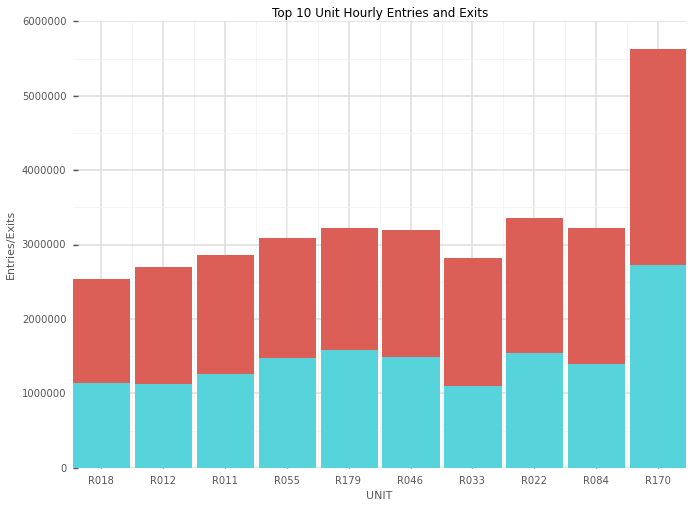

<ggplot: (15644238)>

In [31]:
plot_top

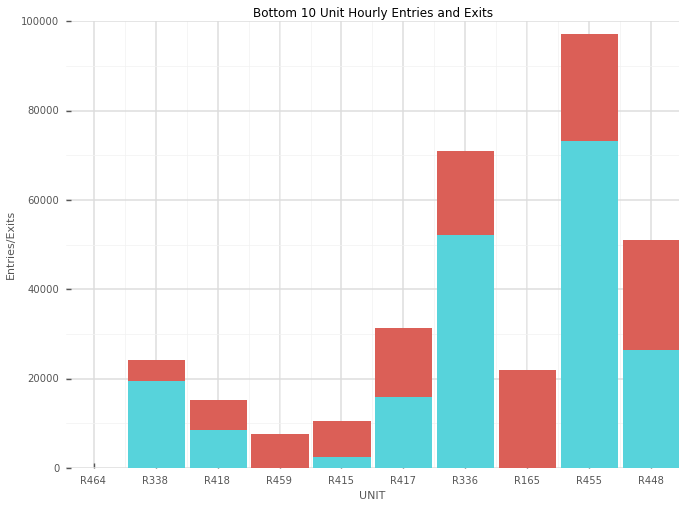

<ggplot: (15276548)>

In [32]:
plot_bot

##Linear Regression##
It would be useful to be able to predict ridership, linear regression is one method that may be used to do this.  Based on my exploration of the data I have determined that useful predictors for ridership may be:
- Rain/Precipitation
- Unit
- Weekday vs. Weekend
- Hour

Unit is accounted for in the feature set below by use of a dummy variable, because Unit is categorical.  Weekday vs. Weekend is not part of the DataFrame we are working with.  I will make my initial prediction below, then try to account of Weekday vs. Weekend with another function.

In [33]:
import numpy as np
import pandas
from ggplot import *

"""
In this question, you need to:
1) implement the compute_cost() and gradient_descent() procedures
2) Select features (in the predictions procedure) and make predictions.

"""

def normalize_features(array):
   """
   Normalize the features in the data set.
   """
   array_normalized = (array-array.mean())/array.std()
   mu = array.mean()
   sigma = array.std()

   return array_normalized, mu, sigma

def compute_cost(features, values, theta):
    """
    Compute the cost function given a set of features / values, 
    and the values for our thetas.
    
    This can be the same code as the compute_cost function in the lesson #3 exercises,
    but feel free to implement your own.
    """
    
    # your code here
    m = len(values)
    sum_of_square_errors = np.square(np.dot(features, theta) - values).sum()
    cost = sum_of_square_errors / (2*m)
    

    return cost

def gradient_descent(features, values, theta, alpha, num_iterations):
    
    """
    Perform gradient descent given a data set with an arbitrary number of features.
    
    This can be the same gradient descent code as in the lesson #3 exercises,
    but feel free to implement your own.
    """
    
    m = float(len(values))
    cost_history = []

    for i in range(num_iterations):
        # your code here
        # predict values
        predicted_values = np.dot(features, theta) 
        # Calculate new theta
        theta = theta - alpha * (1/m) * np.dot((predicted_values - values),features)
        # Compute cost
        cost = compute_cost(features, values, theta)

        # Append cost to history
        cost_history.append(cost)
    return theta, pandas.Series(cost_history)

def predictions(dataframe):
    '''
    The NYC turnstile data is stored in a pandas dataframe called weather_turnstile.
    Using the information stored in the dataframe, let's predict the ridership of
    the NYC subway using linear regression with gradient descent.
    
    You can download the complete turnstile weather dataframe here:
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv    
    
    Your prediction should have a R^2 value of 0.20 or better.
    You need to experiment using various input features contained in the dataframe. 
    We recommend that you don't use the EXITSn_hourly feature as an input to the 
    linear model because we cannot use it as a predictor: we cannot use exits 
    counts as a way to predict entry counts. 
    
    Note: Due to the memory and CPU limitation of our Amazon EC2 instance, we will
    give you a random subet (~15%) of the data contained in 
    turnstile_data_master_with_weather.csv. You are encouraged to experiment with 
    this computer on your own computer, locally. 
    
    
    If you'd like to view a plot of your cost history, uncomment the call to 
    plot_cost_history below. The slowdown from plotting is significant, so if you 
    are timing out, the first thing to do is to comment out the plot command again.
    
    If you receive a "server has encountered an error" message, that means you are 
    hitting the 30-second limit that's placed on running your program. Try using a 
    smaller number for num_iterations if that's the case.
    
    If you are using your own algorithm/models, see if you can optimize your code so 
    that it runs faster.
    '''
    # Select Features (try different features!)
    features = dataframe[['rain','Hour']]
    
    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe[['ENTRIESn_hourly']]
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)
    
    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values).flatten()

    # Set values for alpha, number of iterations.
    alpha = 0.1 # please feel free to change this value
    num_iterations = 100 # please feel free to change this value

    # Initialize theta, perform gradient descent
    theta_gradient_descent = np.zeros(len(features.columns))
    theta_gradient_descent, cost_history = gradient_descent(features_array, 
                                                            values_array, 
                                                            theta_gradient_descent, 
                                                            alpha, 
                                                            num_iterations)
    
    plot = None
    # -------------------------------------------------
    # Uncomment the next line to see your cost history
    # -------------------------------------------------
    plot = plot_cost_history(alpha, cost_history)
    # 
    # Please note, there is a possibility that plotting
    # this in addition to your calculation will exceed 
    # the 30 second limit on the compute servers.
    
    predictions = np.dot(features_array, theta_gradient_descent)
    return predictions, plot, features


def plot_cost_history(alpha, cost_history):
   """This function is for viewing the plot of your cost history.
   You can run it by uncommenting this

       plot_cost_history(alpha, cost_history) 

   call in predictions.
   
   If you want to run this locally, you should print the return value
   from this function.
   """
   cost_df = pandas.DataFrame({
      'Cost_History': cost_history,
      'Iteration': range(len(cost_history))
   })
   return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
      geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )




In [34]:
preds, cost_plot, features = predictions(df_turnstile_weather)

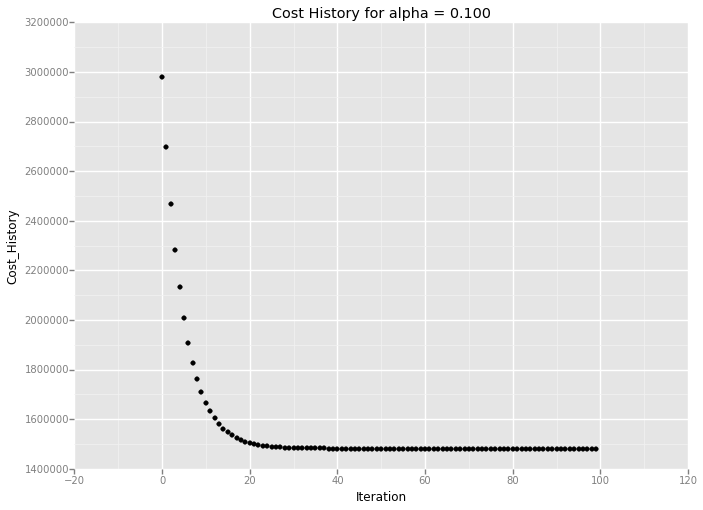

<ggplot: (15275037)>

In [35]:
cost_plot

In [36]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def plot_residuals(turnstile_weather, predictions, start, stop):
    '''
    Using the same methods that we used to plot a histogram of entries
    per hour for our data, why don't you make a histogram of the residuals
    (that is, the difference between the original hourly entry data and the predicted values).

    Based on this residual histogram, do you have any insight into how our model
    performed?  Reading a bit on this webpage might be useful:

    http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm
    '''
    
    plt.figure()
    (turnstile_weather.ENTRIESn_hourly - predictions).hist(bins = 30, range = (start, stop))
    plt.title('Residual Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    return plt

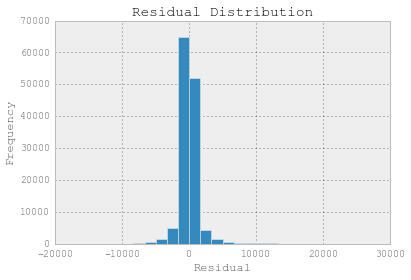

In [37]:
plot_residuals(df_turnstile_weather, preds, -20000,30000);

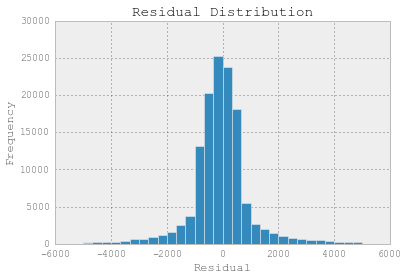

In [38]:
plot_residuals(df_turnstile_weather, preds, -5000,5000);

In [39]:
def compute_r_squared(data, predictions):
    # Write a function that, given two input numpy arrays, 'data', and 'predictions,'
    # returns the coefficient of determination, R^2, for the model that produced 
    # predictions.
    # 
    # Numpy has a couple of functions -- np.mean() and np.sum() --
    # that you might find useful, but you don't have to use them.

    # YOUR CODE GOES HERE
    SST = ((data - np.mean(data))**2).sum()
    SSReg = ((predictions-data)**2).sum()
    r_squared = 1- SSReg/ SST
    
    
   

    return r_squared

In [40]:
compute_r_squared(df_turnstile_weather.ENTRIESn_hourly,preds)

0.45756136309528872

y=0.000033x+(-0.006566)


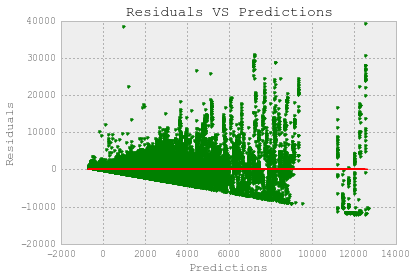

In [41]:
#data

y = df_turnstile_weather.ENTRIESn_hourly - preds
x = preds

# plot the data itself
pylab.plot(x,y,'g.')

# calc the trendline
z = numpy.polyfit(x, y,1)
p = numpy.poly1d(z)
pylab.plot(x,p(x),'r-')
pylab.title('Residuals VS Predictions')
pylab.xlabel('Predictions')
pylab.ylabel('Residuals')
print 'y=%.6fx+(%.6f)'%(z[0],z[1])

##Using Weekday vs. Weekend as a Feature for Predicting Ridership##

In [42]:
import numpy as np
import pandas
from ggplot import *

"""
In this question, you need to:
1) implement the compute_cost() and gradient_descent() procedures
2) Select features (in the predictions procedure) and make predictions.

"""

def normalize_features(array):
   """
   Normalize the features in the data set.
   """
   array_normalized = (array-array.mean())/array.std()
   mu = array.mean()
   sigma = array.std()

   return array_normalized, mu, sigma

def compute_cost(features, values, theta):
    """
    Compute the cost function given a set of features / values, 
    and the values for our thetas.
    
    This can be the same code as the compute_cost function in the lesson #3 exercises,
    but feel free to implement your own.
    """
    
    # your code here
    m = len(values)
    sum_of_square_errors = np.square(np.dot(features, theta) - values).sum()
    cost = sum_of_square_errors / (2*m)
    

    return cost

def gradient_descent(features, values, theta, alpha, num_iterations):
    
    """
    Perform gradient descent given a data set with an arbitrary number of features.
    
    This can be the same gradient descent code as in the lesson #3 exercises,
    but feel free to implement your own.
    """
    
    m = float(len(values))
    cost_history = []

    for i in range(num_iterations):
        # your code here
        # predict values
        predicted_values = np.dot(features, theta) 
        # Calculate new theta
        theta = theta - alpha * (1/m) * np.dot((predicted_values - values),features)
        # Compute cost
        cost = compute_cost(features, values, theta)

        # Append cost to history
        cost_history.append(cost)
    return theta, pandas.Series(cost_history)

def predictions_2(dataframe):
    '''
    The NYC turnstile data is stored in a pandas dataframe called weather_turnstile.
    Using the information stored in the dataframe, let's predict the ridership of
    the NYC subway using linear regression with gradient descent.
    
    You can download the complete turnstile weather dataframe here:
    https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv    
    
    Your prediction should have a R^2 value of 0.20 or better.
    You need to experiment using various input features contained in the dataframe. 
    We recommend that you don't use the EXITSn_hourly feature as an input to the 
    linear model because we cannot use it as a predictor: we cannot use exits 
    counts as a way to predict entry counts. 
    
    Note: Due to the memory and CPU limitation of our Amazon EC2 instance, we will
    give you a random subet (~15%) of the data contained in 
    turnstile_data_master_with_weather.csv. You are encouraged to experiment with 
    this computer on your own computer, locally. 
    
    
    If you'd like to view a plot of your cost history, uncomment the call to 
    plot_cost_history below. The slowdown from plotting is significant, so if you 
    are timing out, the first thing to do is to comment out the plot command again.
    
    If you receive a "server has encountered an error" message, that means you are 
    hitting the 30-second limit that's placed on running your program. Try using a 
    smaller number for num_iterations if that's the case.
    
    If you are using your own algorithm/models, see if you can optimize your code so 
    that it runs faster.
    '''
    # Select Features (try different features!)
    features = dataframe[['rain','Hour','isWeekday','maxtempi']]
    
    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe[['ENTRIESn_hourly']]
    m = len(values)

    features, mu, sigma = normalize_features(features)
    features['ones'] = np.ones(m) # Add a column of 1s (y intercept)
    
    # Convert features and values to numpy arrays
    features_array = np.array(features)
    values_array = np.array(values).flatten()

    # Set values for alpha, number of iterations.
    alpha = 0.1 # please feel free to change this value
    num_iterations = 100 # please feel free to change this value

    # Initialize theta, perform gradient descent
    theta_gradient_descent = np.zeros(len(features.columns))
    theta_gradient_descent, cost_history = gradient_descent(features_array, 
                                                            values_array, 
                                                            theta_gradient_descent, 
                                                            alpha, 
                                                            num_iterations)
    
    plot = None
    # -------------------------------------------------
    # Uncomment the next line to see your cost history
    # -------------------------------------------------
    plot = plot_cost_history(alpha, cost_history)
    # 
    # Please note, there is a possibility that plotting
    # this in addition to your calculation will exceed 
    # the 30 second limit on the compute servers.
    
    predictions = np.dot(features_array, theta_gradient_descent)
    return predictions, plot, features


def plot_cost_history(alpha, cost_history):
   """This function is for viewing the plot of your cost history.
   You can run it by uncommenting this

       plot_cost_history(alpha, cost_history) 

   call in predictions.
   
   If you want to run this locally, you should print the return value
   from this function.
   """
   cost_df = pandas.DataFrame({
      'Cost_History': cost_history,
      'Iteration': range(len(cost_history))
   })
   return ggplot(cost_df, aes('Iteration', 'Cost_History')) + \
      geom_point() + ggtitle('Cost History for alpha = %.3f' % alpha )




**Steps**
- Convert DATEn to date object
- Create column isWeekday where 1 is weekday (weekday = True) and 0 is a weekend (weekday = False)

I'm doing it this way to avoid a categorical variable, especially since particular days of the week do not appear predictive, only whether it is a weekend, or not a weekend.  I'm treating this just like Rain or No Rain.

In [43]:
df_turnstile_weather['DATEn']= pd.to_datetime(df_turnstile_weather.DATEn, format='%Y-%m-%d')

In [44]:
dict_isWeekday = {0: 1, 1:1, 2:1, 3:1, 4:1, 5:0, 6: 0}

In [45]:
df_turnstile_weather['isWeekday']= df_turnstile_weather.DATEn.apply(lambda x: dict_isWeekday[x.weekday()])

Let's make sure we only have 0 or 1 for the isWeekday column

In [46]:
set(df_turnstile_weather.isWeekday)

{0, 1}

In [47]:
preds2,costplot2,features2 = predictions_2(df_turnstile_weather)

In [48]:
compute_r_squared(df_turnstile_weather.ENTRIESn_hourly,preds2)

0.46843947373062145

A marginal increase in r^2 as a result of applying the is_weekday feature set.  There is another small (very small boost) from including temp data.

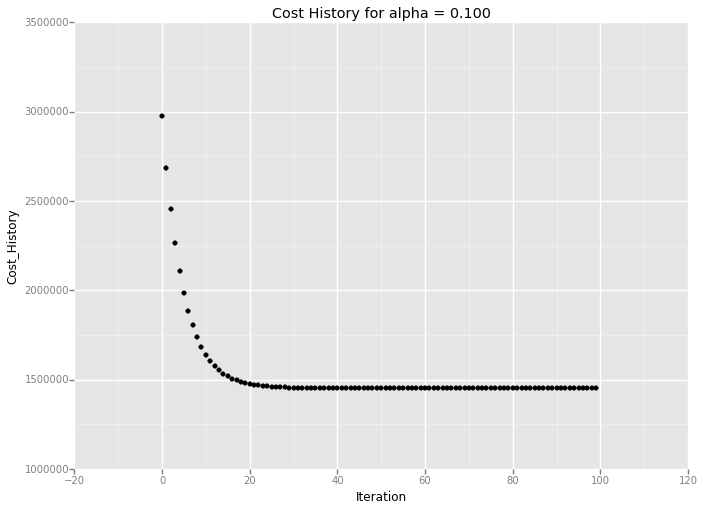

<ggplot: (12162098)>

In [49]:
costplot2

**References**

- GGPlot ( http://ggplot.yhathq.com/docs/index.html )
- http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit
- https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php
- http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm
- Class Page on Piazza
- Python for Data Analysis by Wes McKinney 
- Stack Overflow
- The ether
